In [1]:
import os
import glob
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import torch

import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 9)})

In [2]:
EXP = "quadratic6"
log_dir = f"outputs/{EXP}"
irrelevant_args = ["B", "Length", "n", "f", "agg", "lr"]

In [3]:
exp_df_list = []
for path in glob.glob(f"{log_dir}/*/*/stats"):
    # Parse logfile
    with open(path, "r") as f:
        lines = f.readlines()
        lines = [re.sub("tensor\(([^)]+)\)", '0.0', line) for line in lines]  # XXX: temporary fix
        stats = [ast.literal_eval(line) for line in lines]
        # Extract _meta variable
        for stat in stats:
            stat["type"] = stat["_meta"]["type"]
            del stat["_meta"]
    # Construct experiment dataframe
    stats_df = pd.DataFrame(stats)

    # Extract main args from path name
    experiment_dir = os.path.dirname(path)
    strategy = os.path.basename(os.path.dirname(experiment_dir))
    args_str = os.path.basename(experiment_dir)
    args_list = args_str.split("_")
    args_dict = {
        "n": int(args_list[0][1:]),
        "f": int(args_list[1][1:]),
        "agg": args_list[2],
        "attack": args_list[3],
        "lr": float(args_list[4][2:]),
        "seed": int(args_list[5][4:]),
        "worker_steps": int(args_list[6][6:]),
        "strategy": strategy,
    }
    # Add args to stats dataframe
    for argname, argvalue in args_dict.items():
        stats_df[argname] = argvalue

    exp_df_list.append(stats_df)

# Concat dataframes and remove irrelevant args
exp_df = pd.concat(exp_df_list).reset_index(drop=True).drop(columns=irrelevant_args)
# Take only validation loss
exp_df = exp_df[exp_df["type"] == "validation"].drop(columns=["type"])
display(exp_df)

,E,Loss,attack,seed,worker_steps,strategy
2,1,0.089671,BF,1,1,sgd_cc
5,2,-0.021332,BF,1,1,sgd_cc
8,3,-0.031352,BF,1,1,sgd_cc
11,4,-0.055045,BF,1,1,sgd_cc
14,5,-0.055652,BF,1,1,sgd_cc
...,...,...,...,...,...,...
42437,46,-0.097712,IPM,3,1,sgd_robust
42440,47,-0.085070,IPM,3,1,sgd_robust
42443,48,-0.087769,IPM,3,1,sgd_robust
42446,49,-0.070484,IPM,3,1,sgd_robust


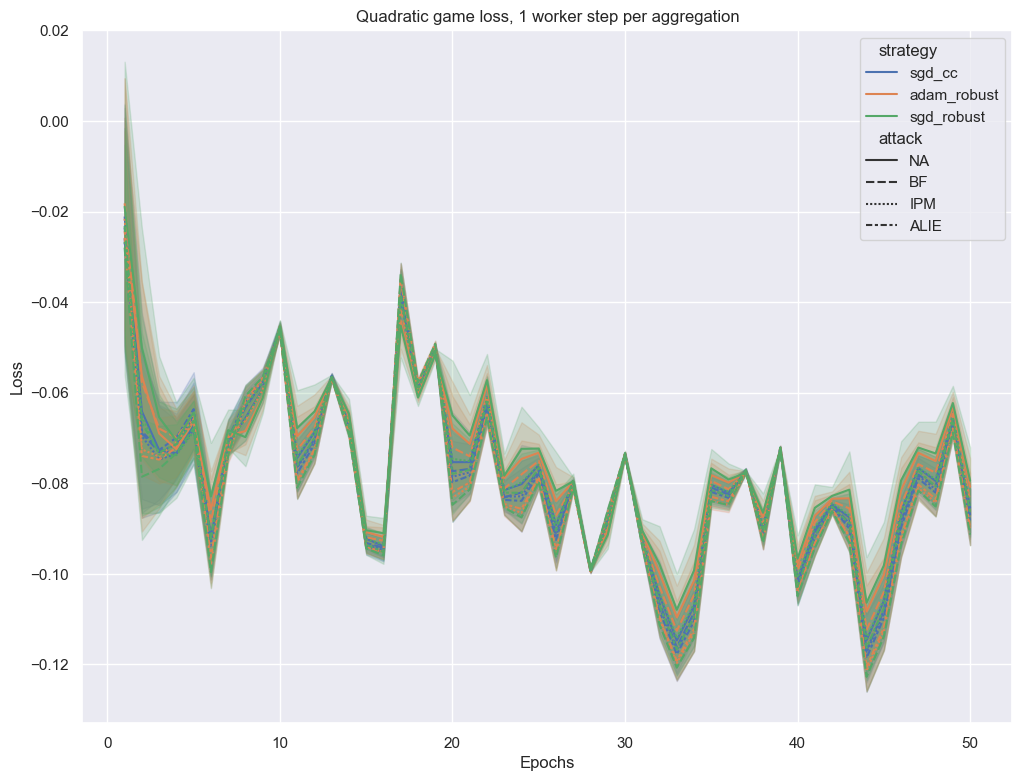

In [4]:
sns.lineplot(data=exp_df[exp_df["worker_steps"] == 1],
    x="E", y="Loss", hue="strategy", style="attack", style_order=["NA", "BF", "IPM", "ALIE"])
plt.title("Quadratic game loss, 1 worker step per aggregation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.yscale("log")
plt.savefig(f"outputs/quadratic.pdf")

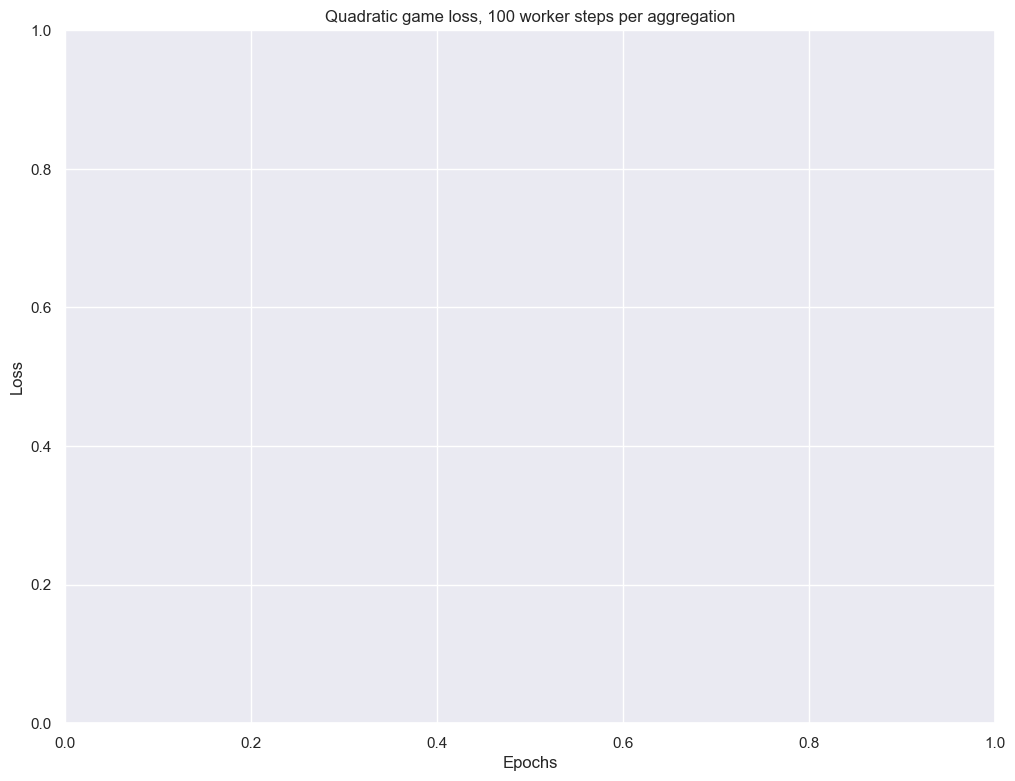

In [5]:
sns.lineplot(data=exp_df[exp_df["worker_steps"] == 12],
    x="E", y="Loss", hue="strategy", style="attack", style_order=["NA", "BF", "IPM", "ALIE"])
plt.title("Quadratic game loss, 100 worker steps per aggregation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(f"outputs/quadratic100.pdf")